In [1]:
train_dir = 'D:/Documentos/Estudio/Maestría/1-Periodo/Aprendizaje_Computacional/Modelopropio/Database/Lung Segmentation Data/Lung Segmentation Data/Train' 
val_dir = 'D:/Documentos/Estudio/Maestría/1-Periodo/Aprendizaje_Computacional/Modelopropio/Database/Lung Segmentation Data/Lung Segmentation Data/Val' 
test_dir = 'D:/Documentos/Estudio/Maestría/1-Periodo/Aprendizaje_Computacional/Modelopropio/Database/Lung Segmentation Data/Lung Segmentation Data/Test'

In [6]:
#ELEGIMOS LOS PARAMETROS
from keras.preprocessing.image import ImageDataGenerator
ih, iw = 224,224 #tamano de la imagen
input_shape = (ih, iw, 3) #forma de la imagen: alto ancho y numero de canales

num_class = 2 #cuantas clases 
#epochs = 15 #cuantas veces entrenar. En cada epoch hace una mejora en los parametros

batch_size = 32 #batch para hacer cada entrenamiento. Lee 50 'batch_size' imagenes antes de actualizar los parametros. Las carga a memoria
num_train = 21715 #numero de imagenes en train
num_test = 6788 #numero de imagenes en test
num_val=5417

epoch_steps = num_train // batch_size 
test_steps = num_test // batch_size
 

In [7]:
#LEEMOS LAS IMÁGENES 

img_height, img_width=ih, iw

train_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical') # set as training data

validation_generator = train_datagen.flow_from_directory(
    val_dir, # same directory as training data
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical') # set as validation data

test_generator = train_datagen.flow_from_directory(
    test_dir, # same directory as training data
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical') # set as validation data

Found 14507 images belonging to 2 classes.
Found 3615 images belonging to 2 classes.
Found 4535 images belonging to 2 classes.


In [8]:
train=train_generator
val=validation_generator
test=test_generator

In [10]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16, DenseNet121, ResNet152V2, NASNetLarge
from tensorflow.keras.layers import Flatten,Dense,Dropout,BatchNormalization
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.regularizers import l2
from keras.applications import resnet_v2
from keras.applications import nasnet 

nasnet_model = nasnet.NASNetMobile(include_top=False, weights='imagenet',  
                                     input_shape=input_shape) 

nasnet_model.trainable=False
for layer in nasnet_model.layers: 
    layer.trainable = False 

In [6]:
#for layer in Xception_model.layers[:-40]:
#    layer.trainable = False

In [12]:
import pandas as pd 
pd.set_option('max_colwidth', -1)

layers = [(layer, layer.name, layer.trainable) for layer in nasnet_model.layers] 
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

C:\Users\elium\.conda\envs\tfGPU\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at 0x000001C5EE020448>,input_2,False
1,<keras.layers.convolutional.Conv2D object at 0x000001C5EE0204C8>,stem_conv1,False
2,<keras.layers.normalization.BatchNormalization object at 0x000001C30BD78988>,stem_bn1,False
3,<keras.layers.core.Activation object at 0x000001C5EE01CD88>,activation_189,False
4,<keras.layers.convolutional.Conv2D object at 0x000001C5EE00AA48>,reduction_conv_1_stem_1,False
...,...,...,...
764,<keras.layers.merge.Add object at 0x000001C5F94A80C8>,normal_add_3_12,False
765,<keras.layers.merge.Add object at 0x000001C5F94F3808>,normal_add_4_12,False
766,<keras.layers.merge.Add object at 0x000001C5F94F3B48>,normal_add_5_12,False
767,<keras.layers.merge.Concatenate object at 0x000001C5F91C0648>,normal_concat_12,False


In [14]:
nasnet_model.summary()

Model: "NASNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
stem_conv1 (Conv2D)             (None, 111, 111, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
stem_bn1 (BatchNormalization)   (None, 111, 111, 32) 128         stem_conv1[0][0]                 
__________________________________________________________________________________________________
activation_189 (Activation)     (None, 111, 111, 32) 0           stem_bn1[0][0]                   
_____________________________________________________________________________________________

In [15]:
from keras import backend as K
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [16]:
from keras.models import Model 
#from keras.applications.inception_resnet_v2 import preprocess_input
import keras 
import matplotlib.pyplot as plt 
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential 
from keras import optimizers 

# build model architecture 
model = Sequential()
model.add(nasnet_model)
model.add(Flatten())

model.add(Dense(num_class, activation='sigmoid'))
#compile model
model.compile(optimizer=tf.keras.optimizers.SGD(lr=0.0001, momentum=0.9), 
      loss = tf.keras.losses.CategoricalCrossentropy(from_logits = True), 
      metrics=['accuracy',f1_m,precision_m, recall_m])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
NASNet (Model)               (None, 7, 7, 1056)        4269716   
_________________________________________________________________
flatten_1 (Flatten)          (None, 51744)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 103490    
Total params: 4,373,206
Trainable params: 103,490
Non-trainable params: 4,269,716
_________________________________________________________________
None


In [17]:
history = model.fit_generator(train, 
                              epochs=10,  
                              validation_data=val,  
                              verbose=1)

Epoch 1/10
454/454 [==============================] - 56s 123ms/step - loss: 0.5232 - accuracy: 0.7935 - f1_m: 0.7475 - precision_m: 0.7895 - recall_m: 0.7418 - val_loss: 0.6735 - val_accuracy: 0.5242 - val_f1_m: 0.5226 - val_precision_m: 0.5353 - val_recall_m: 0.5109
Epoch 2/10
454/454 [==============================] - 43s 96ms/step - loss: 0.4582 - accuracy: 0.8626 - f1_m: 0.8580 - precision_m: 0.8599 - recall_m: 0.8575 - val_loss: 0.7153 - val_accuracy: 0.5347 - val_f1_m: 0.5309 - val_precision_m: 0.5362 - val_recall_m: 0.5261
Epoch 3/10
454/454 [==============================] - 44s 96ms/step - loss: 0.4421 - accuracy: 0.8776 - f1_m: 0.8739 - precision_m: 0.8749 - recall_m: 0.8740 - val_loss: 0.7511 - val_accuracy: 0.5815 - val_f1_m: 0.5787 - val_precision_m: 0.5887 - val_recall_m: 0.5698
Epoch 4/10
454/454 [==============================] - 44s 96ms/step - loss: 0.4329 - accuracy: 0.8885 - f1_m: 0.8840 - precision_m: 0.8855 - recall_m: 0.8833 - val_loss: 0.6866 - val_accuracy: 0.

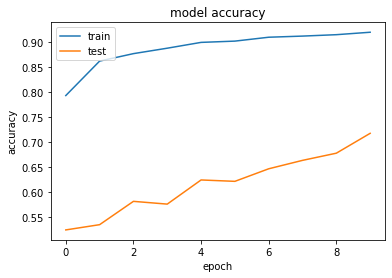

In [18]:
# summarize history for accuracy
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

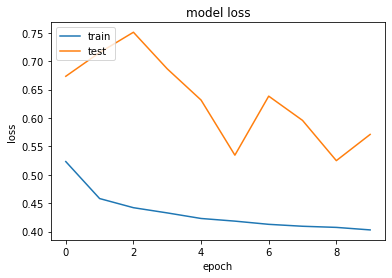

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

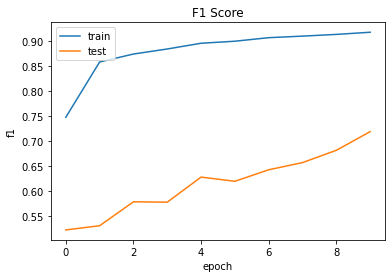

In [20]:
plt.plot(history.history['f1_m'])
plt.plot(history.history['val_f1_m'])
plt.title('F1 Score')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

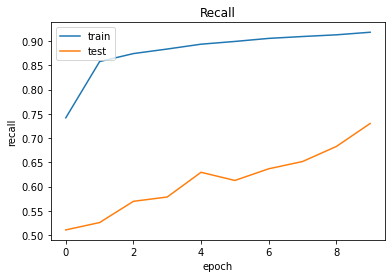

In [21]:
plt.plot(history.history['recall_m'])
plt.plot(history.history['val_recall_m'])
plt.title('Recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

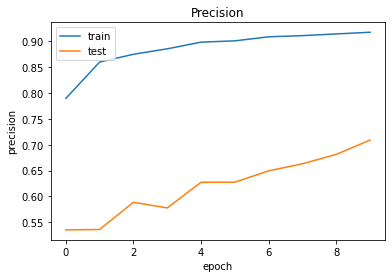

In [22]:
plt.plot(history.history['precision_m'])
plt.plot(history.history['val_precision_m'])
plt.title('Precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [23]:
print('Utilizando el conjunto de datos de test para evaluar el modelo')
test_eval = model.evaluate(test, verbose=1)
print('El modelo predice el ', test_eval[1]*100,'% de los datos')

Utilizando el conjunto de datos de test para evaluar el modelo
142/142 [==============================] - 13s 89ms/step
El modelo predice el  72.30430245399475 % de los datos


In [24]:
print('Utilizando el conjunto de datos de test para evaluar el modelo')
print('Loss: ',test_eval[0])
print('Accuracy: ',test_eval[1])
print('F1 Score: ',test_eval[2])
print('Precision: ',test_eval[3])
print('Recall: ',test_eval[4])

Utilizando el conjunto de datos de test para evaluar el modelo
Loss:  0.6045563817024231
Accuracy:  0.7230430245399475
F1 Score:  0.7242196798324585
Precision:  0.7147740721702576
Recall:  0.7347003221511841
